In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

# Import Data Sisaan

In [2]:
np.random.seed(7)

In [3]:
data = pd.read_excel("/content/Data Daily 2023-2025.xlsx")
data = data.loc[:, ['Daily_Period','TMA_Daily']]
data = data.iloc[:731].reset_index(drop=True)
print(data.head())
print(data.tail())
print(data.shape)

  Daily_Period  TMA_Daily
0   2023-01-01  43.750000
1   2023-01-02  36.666667
2   2023-01-03  32.916667
3   2023-01-04  32.173913
4   2023-01-05  30.000000
    Daily_Period  TMA_Daily
726   2024-12-27  20.000000
727   2024-12-28  15.000000
728   2024-12-29  11.250000
729   2024-12-30  11.666667
730   2024-12-31  10.000000
(731, 2)


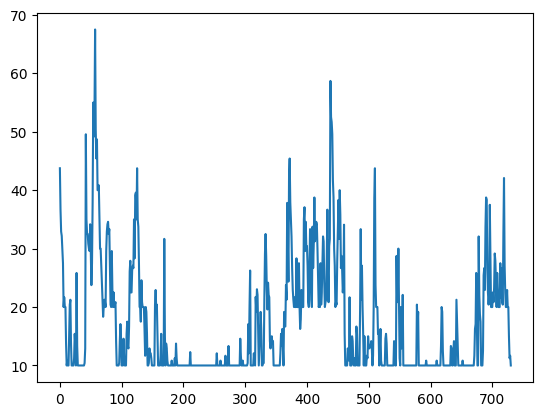

In [4]:
plt.plot(data['TMA_Daily'])

## Normalisasi Data

Proses normalisasi data dilakukan menggunakan metode min-max normalization hingga menghasilkan data yang berskala [0,1].

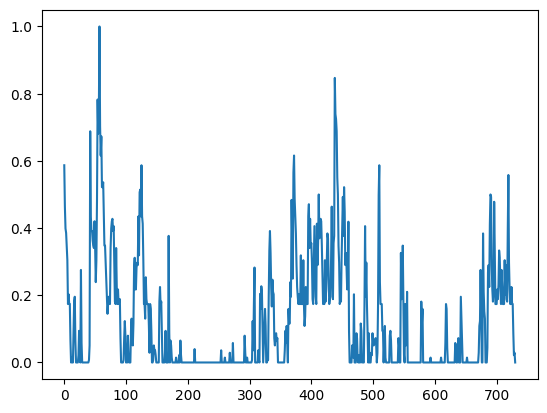

In [5]:
# Step 1: Normalize the data using Min-Max scaling
scaler = MinMaxScaler()
data['TMA_normalized'] = scaler.fit_transform(data['TMA_Daily'].values.reshape(-1, 1))
plt.plot(data['TMA_normalized'])

# Hyperparameter Tuning

Hyperparameter tuning dilakukan untuk menentukan hyperparameter terbaik melalui langkah validasi berupa *time series k-fold cross validation*. Banyaknya fold yang digunakan dalam langkah validasi adalah sebanyak k = 5.

EXPANDING WINDOW

## Skenario 1

### Learning Rate (0,001) dan Batch Size (16)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


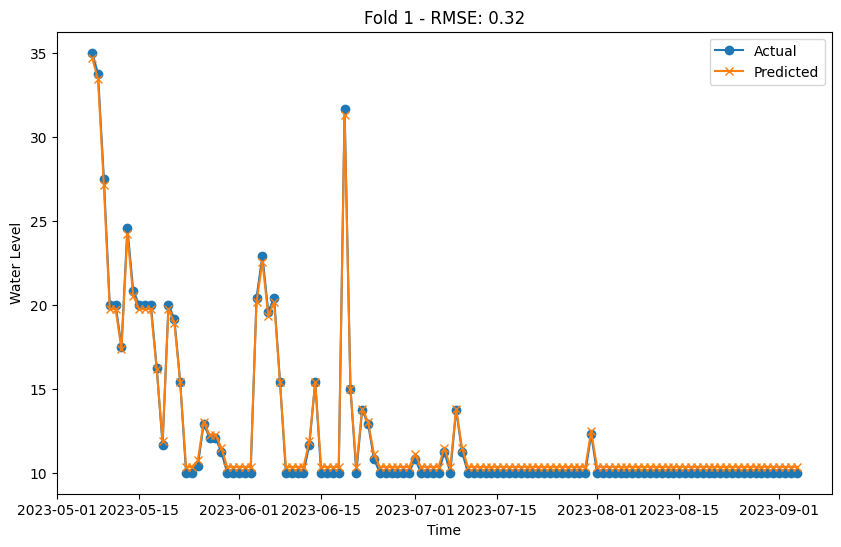

Fold 1 - RMSE: 0.32


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


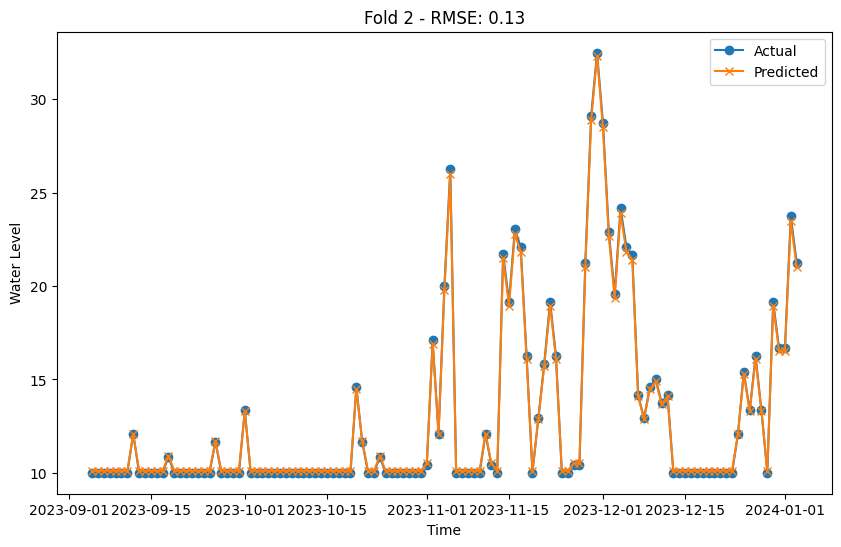

Fold 2 - RMSE: 0.13


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


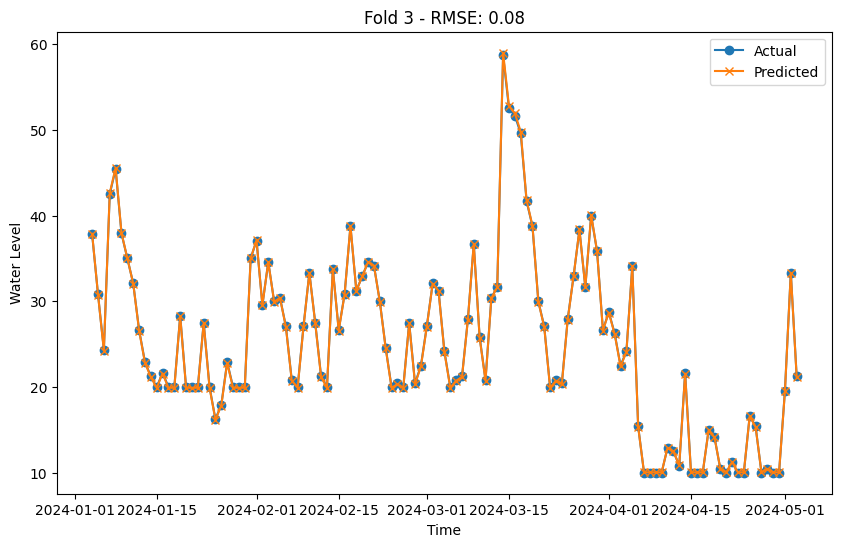

Fold 3 - RMSE: 0.08


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


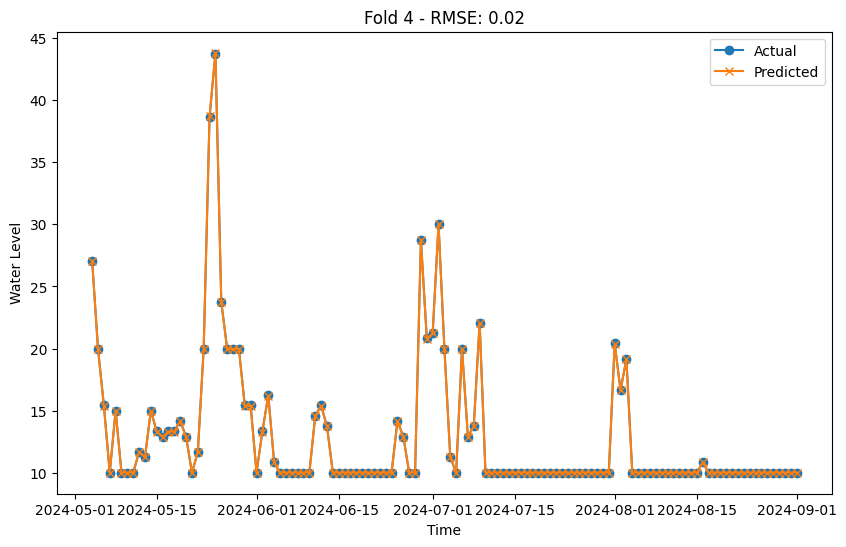

Fold 4 - RMSE: 0.02


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


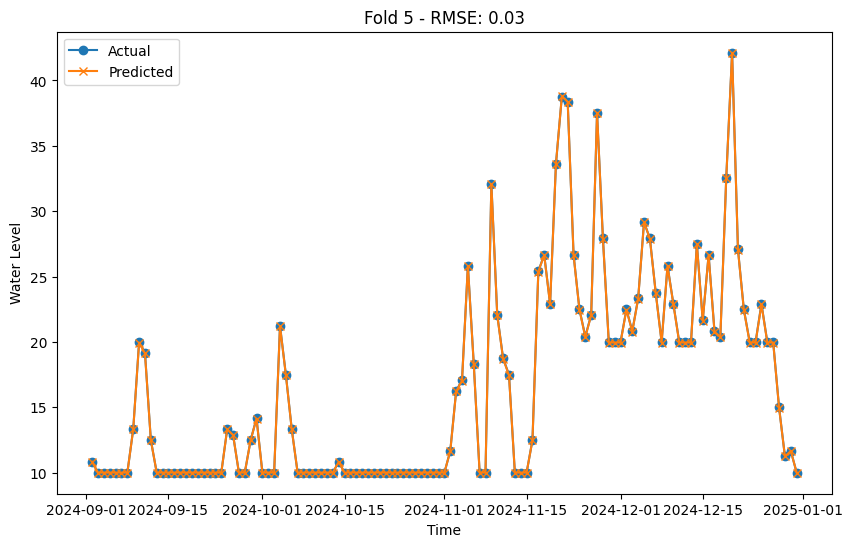

Fold 5 - RMSE: 0.03


In [6]:
# LEARNING RATE: 0,001 dan BATCH SIZE: 16

from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import Adam

# Define hyperparameters
learning_rate = 0.001
batch_size = 16
epochs = 100
neurons = 40
time_step = 30

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Initialize list to store RMSE values for each fold
rmse_values = []

# Iterate over each fold
for i, (train_index, test_index) in enumerate(tscv.split(data['TMA_normalized'])):
    train_data, test_data = data.iloc[train_index], data.iloc[test_index]

    # Create and train LSTM model
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(time_step, 1)))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)  # Inisialisasi optimizer dengan learning rate
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    model.fit(train_data['TMA_normalized'].values.reshape(-1, 1),
              train_data['TMA_normalized'].values.reshape(-1, 1),
              epochs=epochs, batch_size=batch_size, verbose=0)

    # Make predictions
    predictions = model.predict(test_data['TMA_normalized'].values.reshape(-1, 1))
    denormalized_predictions = scaler.inverse_transform(predictions)

    # Calculate RMSE
    actual_values = test_data['TMA_Daily'].values
    rmse = np.sqrt(mean_squared_error(actual_values, denormalized_predictions))
    rmse_values.append(rmse)

    # Plot predictions
    plt.figure(figsize=(10, 6))
    plt.plot(test_data['Daily_Period'], actual_values, label='Actual', marker='o')
    plt.plot(test_data['Daily_Period'], denormalized_predictions, label='Predicted', marker='x')
    plt.title(f"Fold {i+1} - RMSE: {rmse:.2f}")
    plt.xlabel('Time')
    plt.ylabel('Water Level')
    plt.legend()
    plt.show()

    print(f"Fold {i+1} - RMSE: {rmse:.2f}")

## Skenario 2

### Learning Rate (0,005) dan Batch Size (16)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


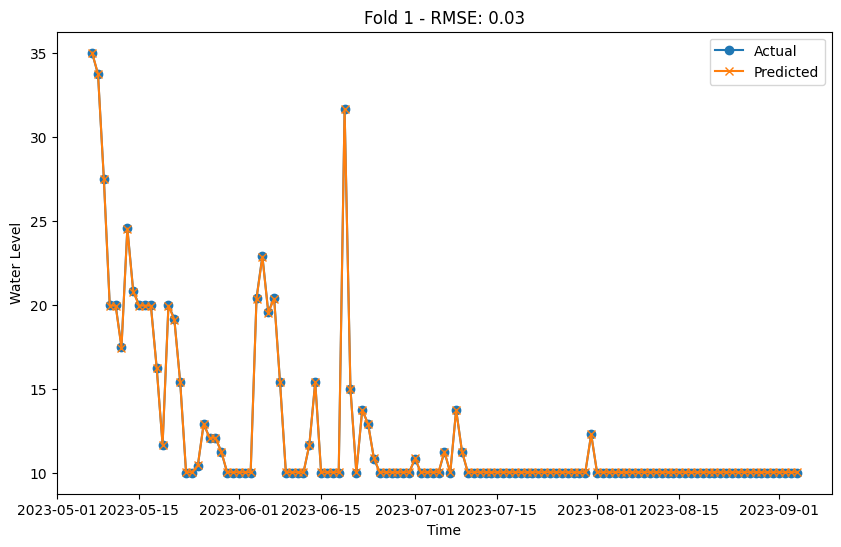

Fold 1 - RMSE: 0.03


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


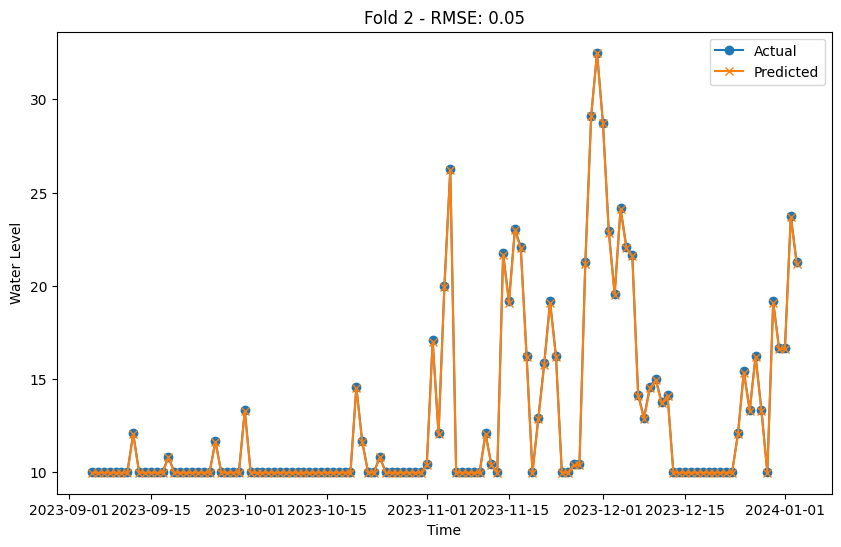

Fold 2 - RMSE: 0.05


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


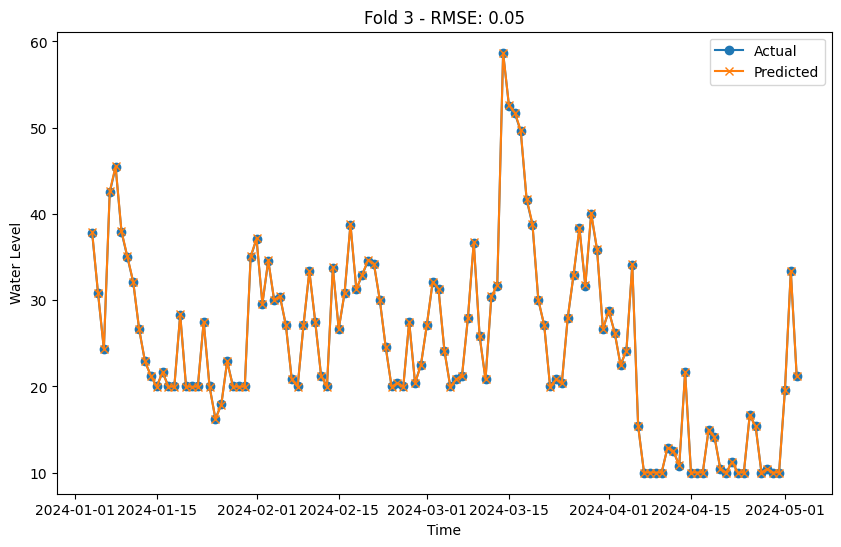

Fold 3 - RMSE: 0.05


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


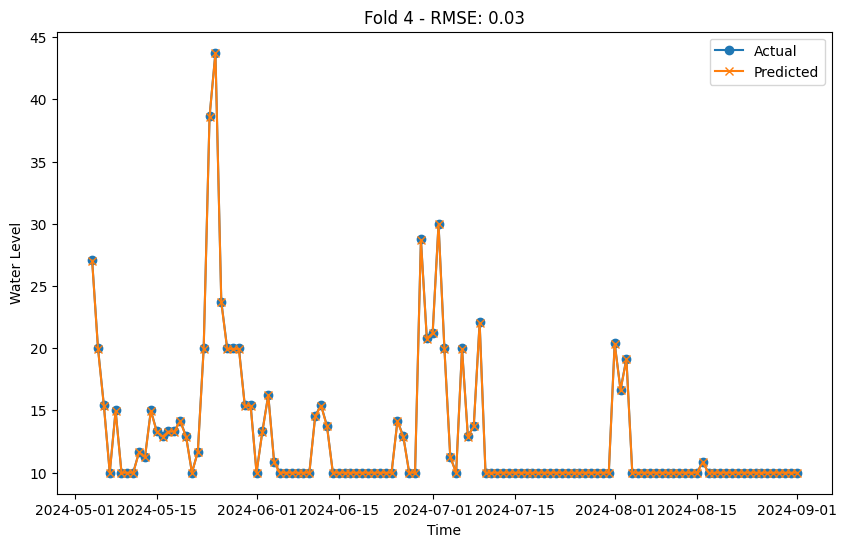

Fold 4 - RMSE: 0.03


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


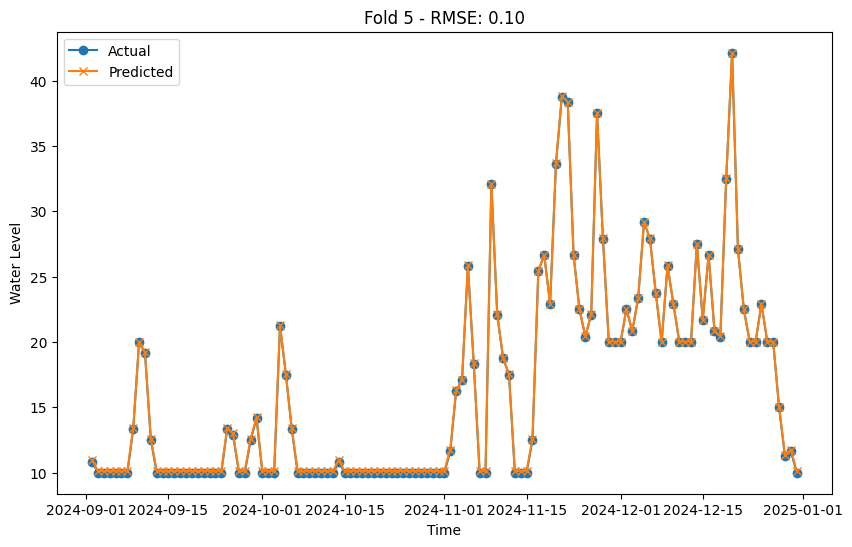

Fold 5 - RMSE: 0.10


In [7]:
#LEARNING RATE: 0,005 dan BATCH SIZE: 16

from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import Adam

# Define hyperparameters
learning_rate = 0.005
batch_size = 16
epochs = 100
neurons = 40
time_step = 30

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Initialize list to store RMSE values for each fold
rmse_values = []

# Iterate over each fold
for i, (train_index, test_index) in enumerate(tscv.split(data['TMA_normalized'])):
    train_data, test_data = data.iloc[train_index], data.iloc[test_index]

    # Create and train LSTM model
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(time_step, 1)))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)  # Inisialisasi optimizer dengan learning rate
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    model.fit(train_data['TMA_normalized'].values.reshape(-1, 1),
              train_data['TMA_normalized'].values.reshape(-1, 1),
              epochs=epochs, batch_size=batch_size, verbose=0)

    # Make predictions
    predictions = model.predict(test_data['TMA_normalized'].values.reshape(-1, 1))
    denormalized_predictions = scaler.inverse_transform(predictions)

    # Calculate RMSE
    actual_values = test_data['TMA_Daily'].values
    rmse = np.sqrt(mean_squared_error(actual_values, denormalized_predictions))
    rmse_values.append(rmse)

    # Plot predictions
    plt.figure(figsize=(10, 6))
    plt.plot(test_data['Daily_Period'], actual_values, label='Actual', marker='o')
    plt.plot(test_data['Daily_Period'], denormalized_predictions, label='Predicted', marker='x')
    plt.title(f"Fold {i+1} - RMSE: {rmse:.2f}")
    plt.xlabel('Time')
    plt.ylabel('Water Level')
    plt.legend()
    plt.show()

    print(f"Fold {i+1} - RMSE: {rmse:.2f}")

## Skenario 3

### Learning Rate (0,001) dan Batch Size (32)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step


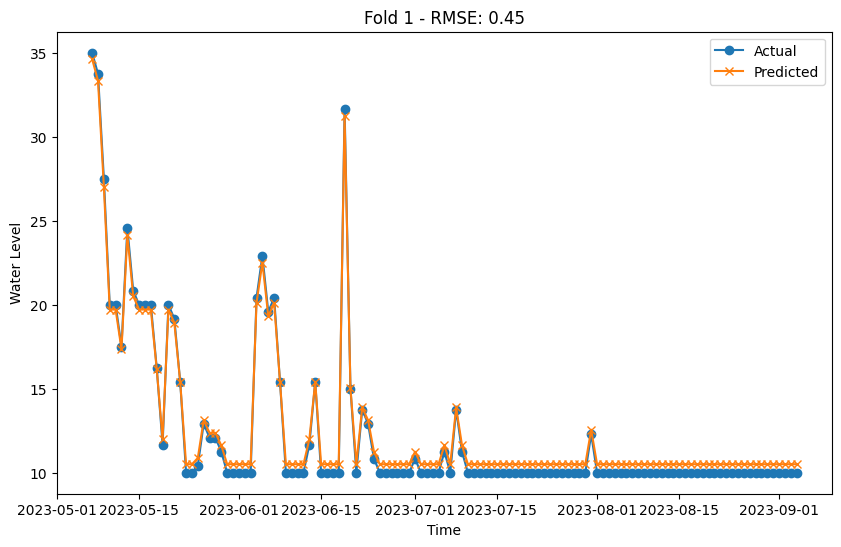

Fold 1 - RMSE: 0.45


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


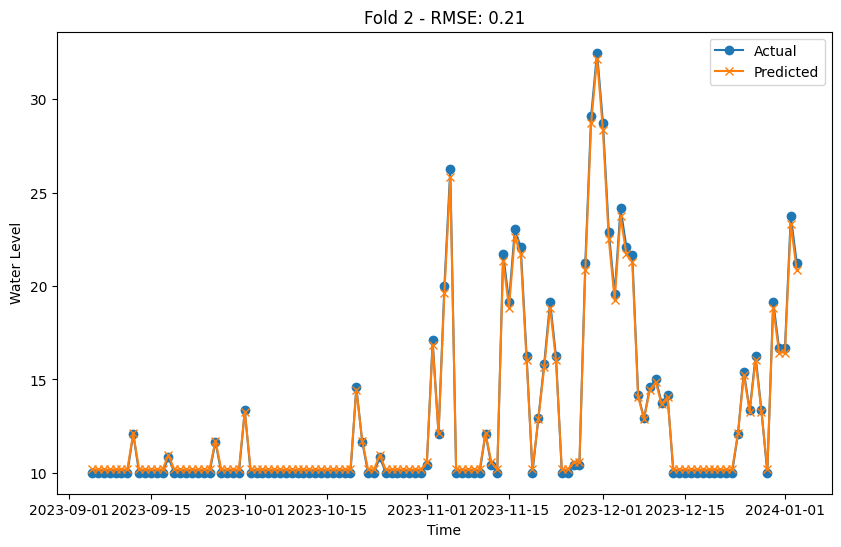

Fold 2 - RMSE: 0.21


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


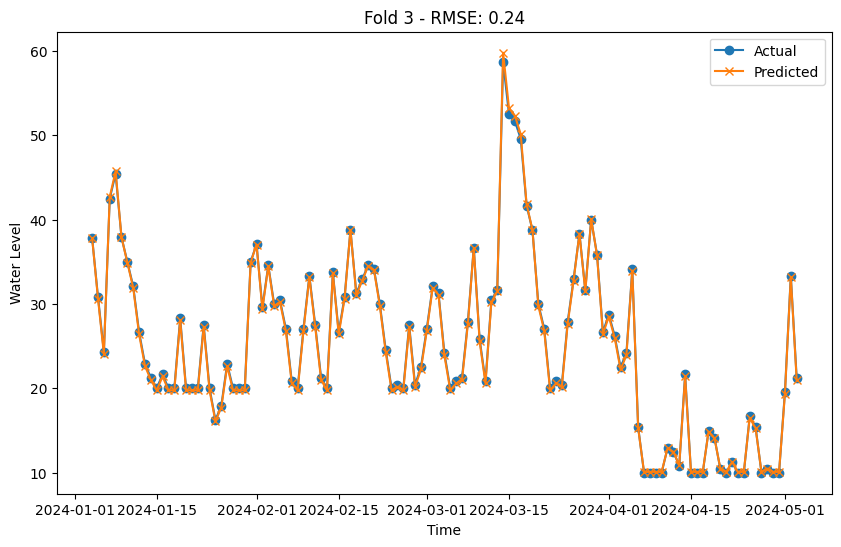

Fold 3 - RMSE: 0.24


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


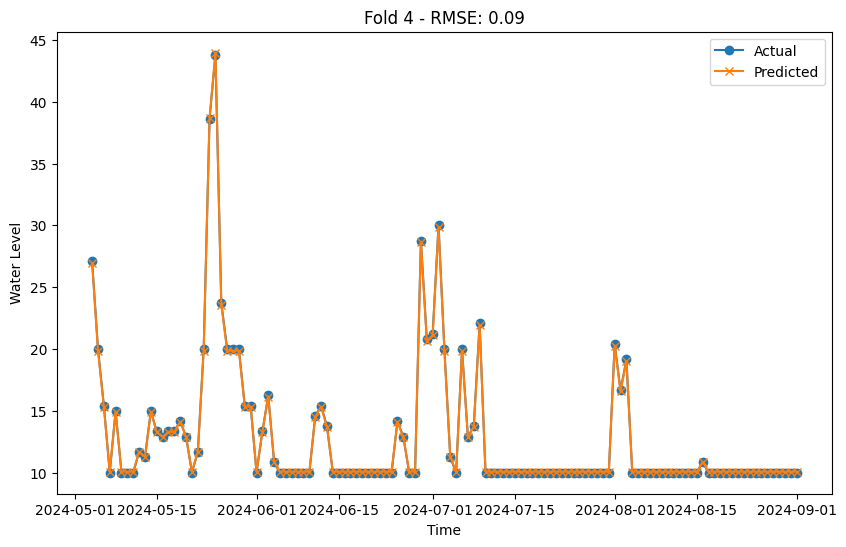

Fold 4 - RMSE: 0.09


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step


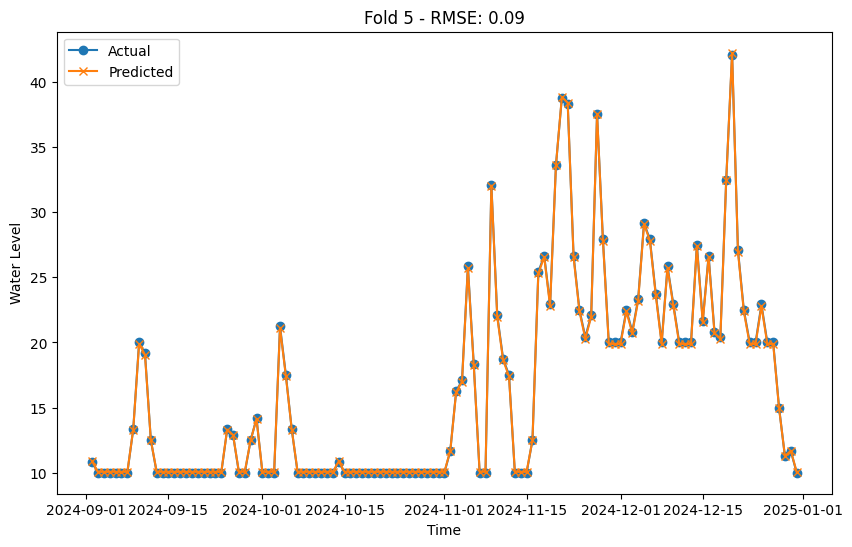

Fold 5 - RMSE: 0.09


In [8]:
#LEARNING RATE: 0,001 dan BATCH SIZE: 32

from sklearn.metrics import mean_squared_error

# Define hyperparameters
learning_rate = 0.001
batch_size = 32
epochs = 100
neurons = 40
time_step = 30

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Initialize list to store RMSE values for each fold
rmse_values = []

# Iterate over each fold
for i, (train_index, test_index) in enumerate(tscv.split(data['TMA_normalized'])):
    train_data, test_data = data.iloc[train_index], data.iloc[test_index]

    # Create and train LSTM model
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(time_step, 1)))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)  # Inisialisasi optimizer dengan learning rate
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    model.fit(train_data['TMA_normalized'].values.reshape(-1, 1),
              train_data['TMA_normalized'].values.reshape(-1, 1),
              epochs=epochs, batch_size=batch_size, verbose=0)

    # Make predictions
    predictions = model.predict(test_data['TMA_normalized'].values.reshape(-1, 1))
    denormalized_predictions = scaler.inverse_transform(predictions)

    # Calculate RMSE
    actual_values = test_data['TMA_Daily'].values
    rmse = np.sqrt(mean_squared_error(actual_values, denormalized_predictions))
    rmse_values.append(rmse)

    # Plot predictions
    plt.figure(figsize=(10, 6))
    plt.plot(test_data['Daily_Period'], actual_values, label='Actual', marker='o')
    plt.plot(test_data['Daily_Period'], denormalized_predictions, label='Predicted', marker='x')
    plt.title(f"Fold {i+1} - RMSE: {rmse:.2f}")
    plt.xlabel('Time')
    plt.ylabel('Water Level')
    plt.legend()
    plt.show()

    print(f"Fold {i+1} - RMSE: {rmse:.2f}")

## Skenario 4

### Learning Rate (0,005) dan Batch Size (32)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


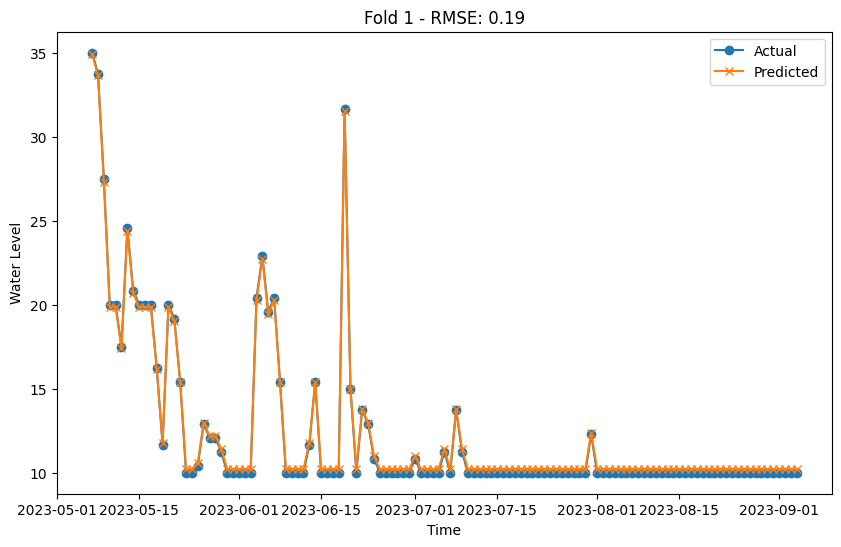

Fold 1 - RMSE: 0.19


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


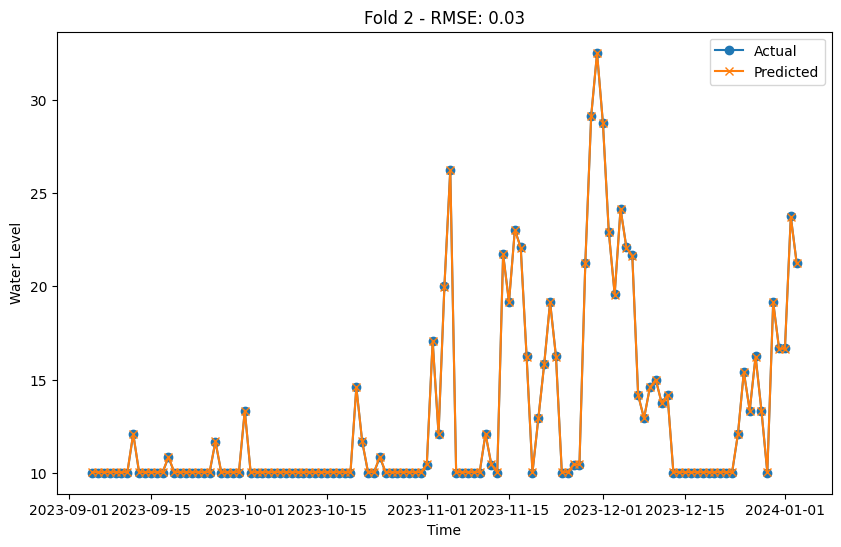

Fold 2 - RMSE: 0.03


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


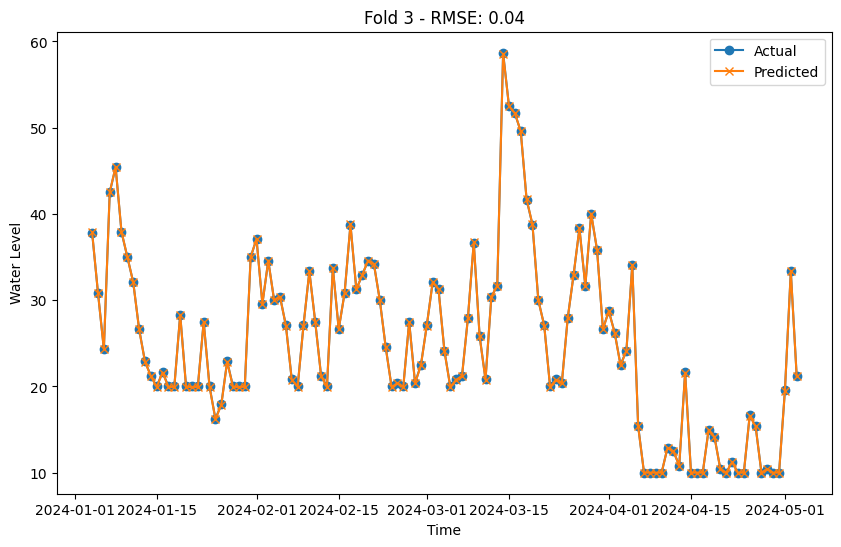

Fold 3 - RMSE: 0.04


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


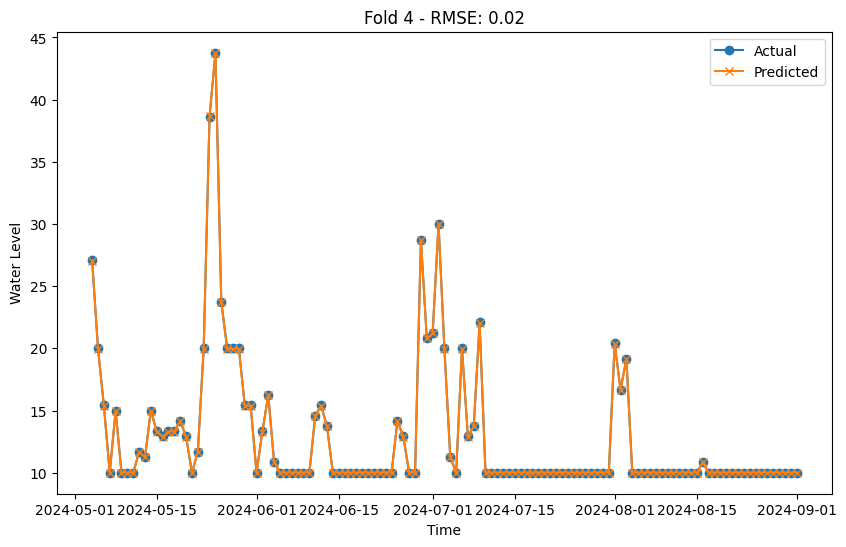

Fold 4 - RMSE: 0.02


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step


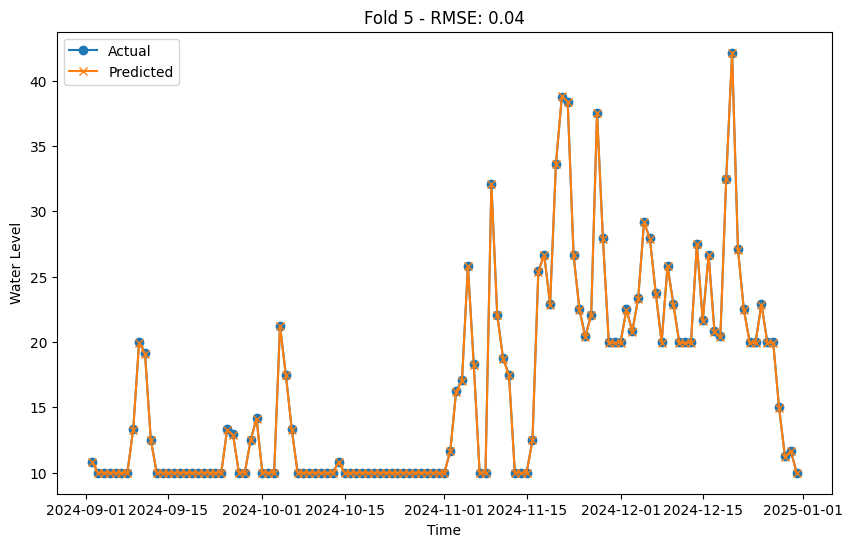

Fold 5 - RMSE: 0.04


In [9]:
#LEARNING RATE: 0,005 dan BATCH SIZE: 32

from sklearn.metrics import mean_squared_error

# Define hyperparameters
learning_rate = 0.005
batch_size = 32
epochs = 100
neurons = 40
time_step = 30

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Initialize list to store RMSE values for each fold
rmse_values = []

# Iterate over each fold
for i, (train_index, test_index) in enumerate(tscv.split(data['TMA_normalized'])):
    train_data, test_data = data.iloc[train_index], data.iloc[test_index]

    # Create and train LSTM model
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(time_step, 1)))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)  # Inisialisasi optimizer dengan learning rate
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    model.fit(train_data['TMA_normalized'].values.reshape(-1, 1),
              train_data['TMA_normalized'].values.reshape(-1, 1),
              epochs=epochs, batch_size=batch_size, verbose=0)

    # Make predictions
    predictions = model.predict(test_data['TMA_normalized'].values.reshape(-1, 1))
    denormalized_predictions = scaler.inverse_transform(predictions)

    # Calculate RMSE
    actual_values = test_data['TMA_Daily'].values
    rmse = np.sqrt(mean_squared_error(actual_values, denormalized_predictions))
    rmse_values.append(rmse)

    # Plot predictions
    plt.figure(figsize=(10, 6))
    plt.plot(test_data['Daily_Period'], actual_values, label='Actual', marker='o')
    plt.plot(test_data['Daily_Period'], denormalized_predictions, label='Predicted', marker='x')
    plt.title(f"Fold {i+1} - RMSE: {rmse:.2f}")
    plt.xlabel('Time')
    plt.ylabel('Water Level')
    plt.legend()
    plt.show()

    print(f"Fold {i+1} - RMSE: {rmse:.2f}")

## Skenario 5

### Learning Rate (0,01) dan Batch Size (16)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


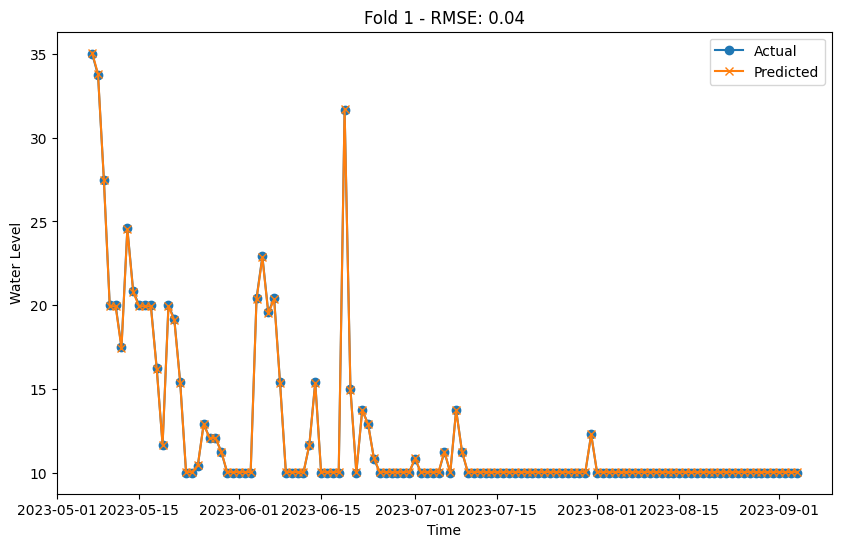

Fold 1 - RMSE: 0.04


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


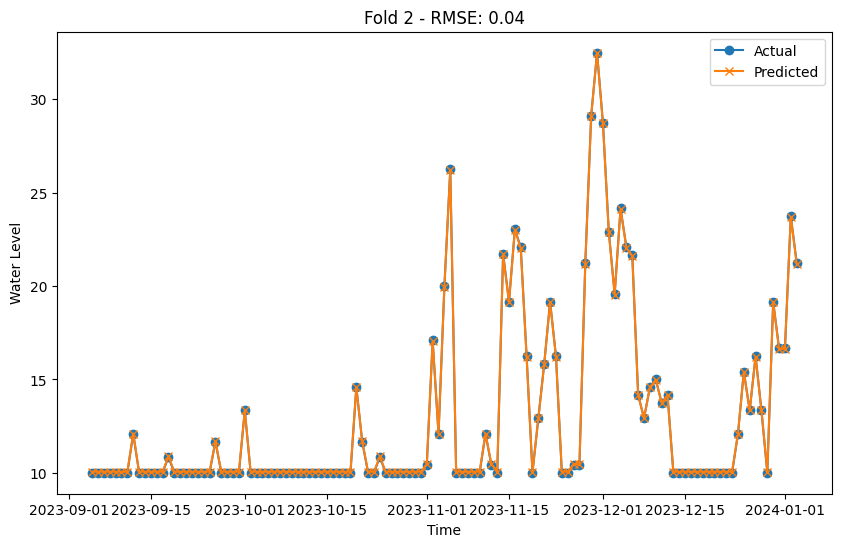

Fold 2 - RMSE: 0.04


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


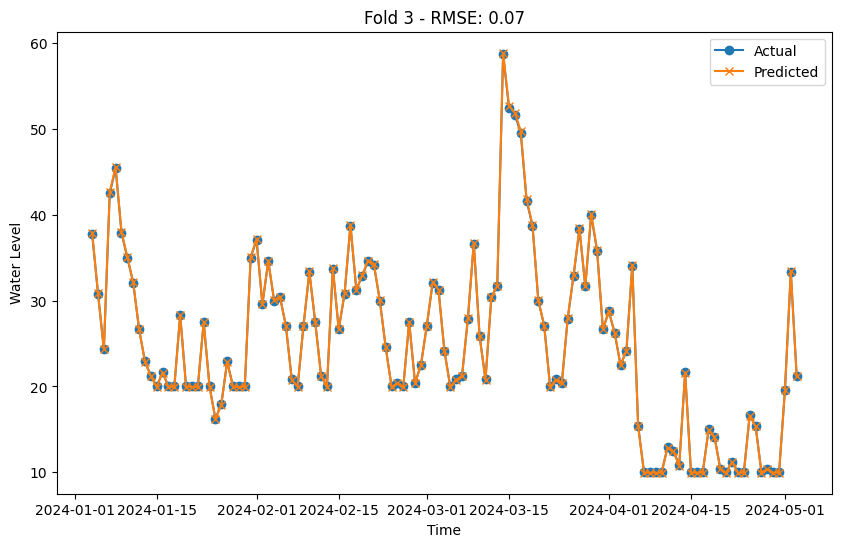

Fold 3 - RMSE: 0.07


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


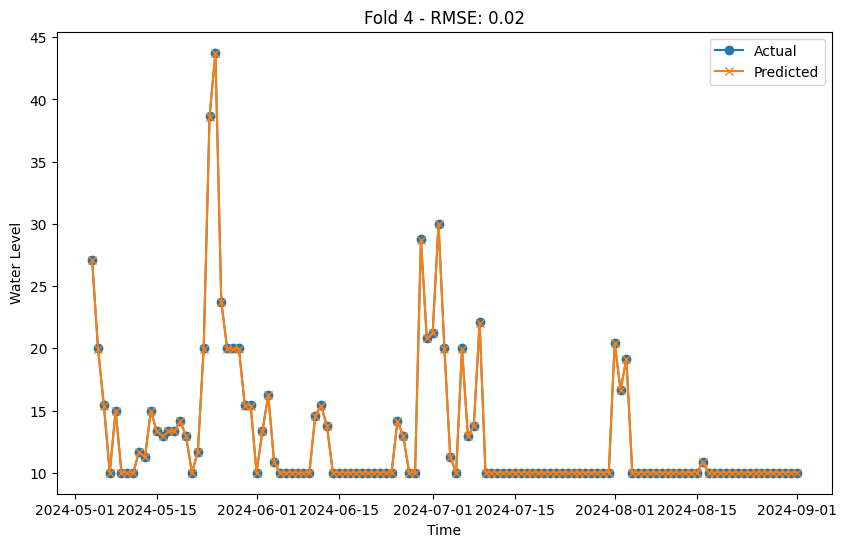

Fold 4 - RMSE: 0.02


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


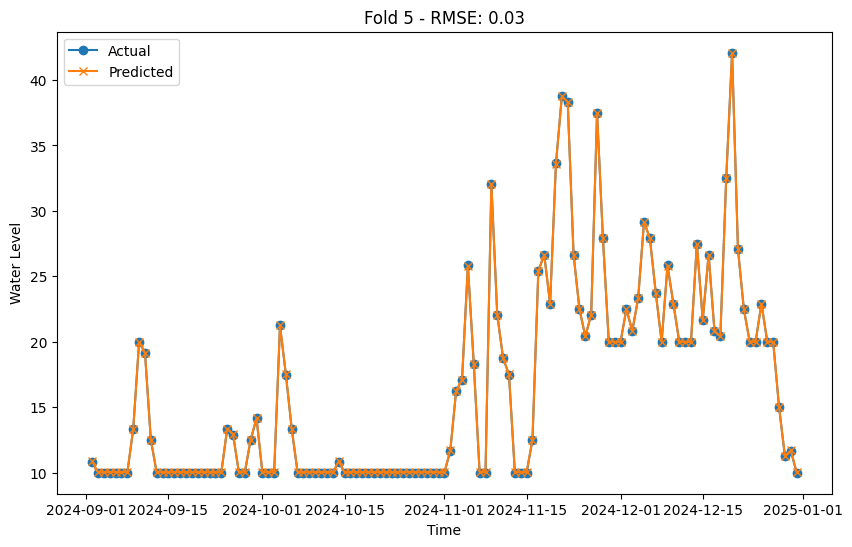

Fold 5 - RMSE: 0.03


In [10]:
#LEARNING RATE: 0,01 dan BATCH SIZE: 16

from sklearn.metrics import mean_squared_error

# Define hyperparameters
learning_rate = 0.01
batch_size = 16
epochs = 100
neurons = 40
time_step = 30

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Initialize list to store RMSE values for each fold
rmse_values = []

# Iterate over each fold
for i, (train_index, test_index) in enumerate(tscv.split(data['TMA_normalized'])):
    train_data, test_data = data.iloc[train_index], data.iloc[test_index]

    # Create and train LSTM model
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(time_step, 1)))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)  # Inisialisasi optimizer dengan learning rate
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    model.fit(train_data['TMA_normalized'].values.reshape(-1, 1),
              train_data['TMA_normalized'].values.reshape(-1, 1),
              epochs=epochs, batch_size=batch_size, verbose=0)

    # Make predictions
    predictions = model.predict(test_data['TMA_normalized'].values.reshape(-1, 1))
    denormalized_predictions = scaler.inverse_transform(predictions)

    # Calculate RMSE
    actual_values = test_data['TMA_Daily'].values
    rmse = np.sqrt(mean_squared_error(actual_values, denormalized_predictions))
    rmse_values.append(rmse)

    # Plot predictions
    plt.figure(figsize=(10, 6))
    plt.plot(test_data['Daily_Period'], actual_values, label='Actual', marker='o')
    plt.plot(test_data['Daily_Period'], denormalized_predictions, label='Predicted', marker='x')
    plt.title(f"Fold {i+1} - RMSE: {rmse:.2f}")
    plt.xlabel('Time')
    plt.ylabel('Water Level')
    plt.legend()
    plt.show()

    print(f"Fold {i+1} - RMSE: {rmse:.2f}")

## Skenario 6

### Learning Rate (0,05) dan Batch Size (16)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


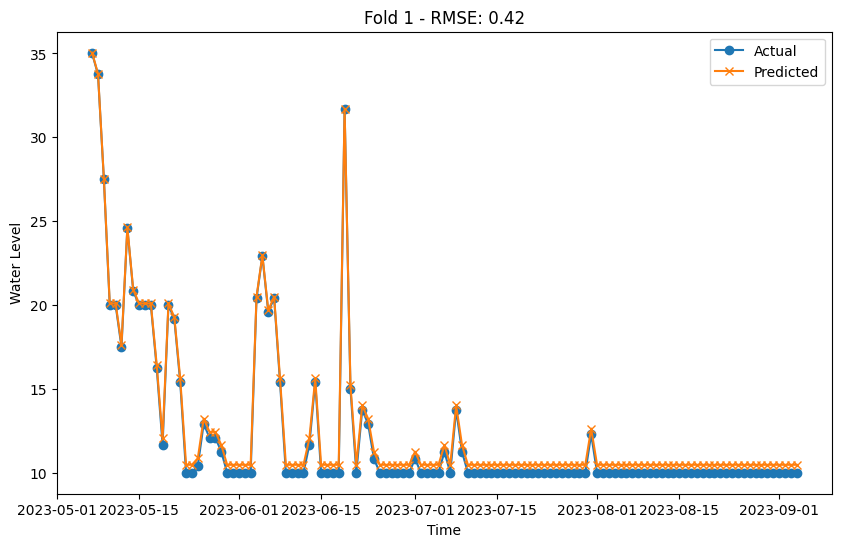

Fold 1 - RMSE: 0.42


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


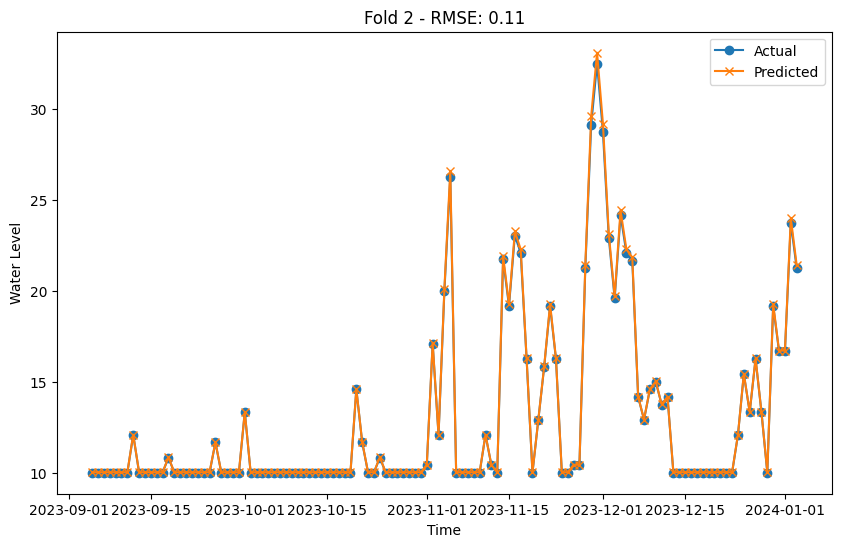

Fold 2 - RMSE: 0.11


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step


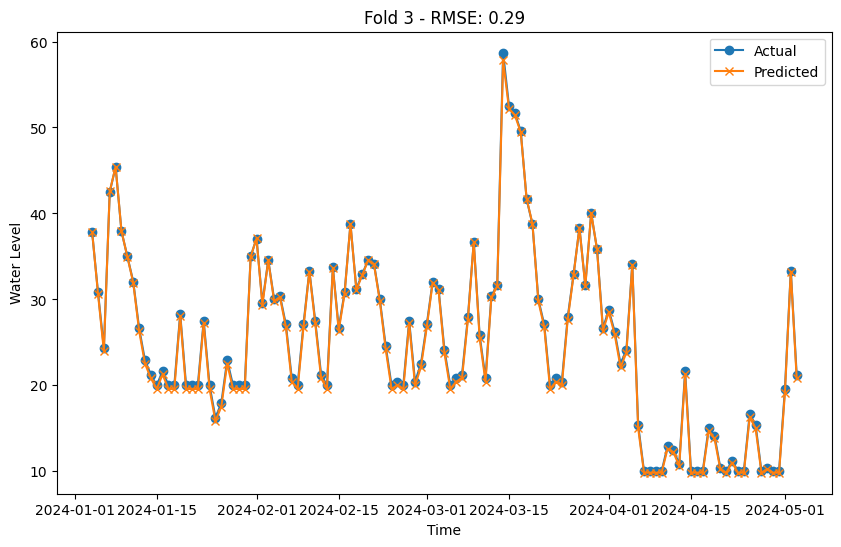

Fold 3 - RMSE: 0.29


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


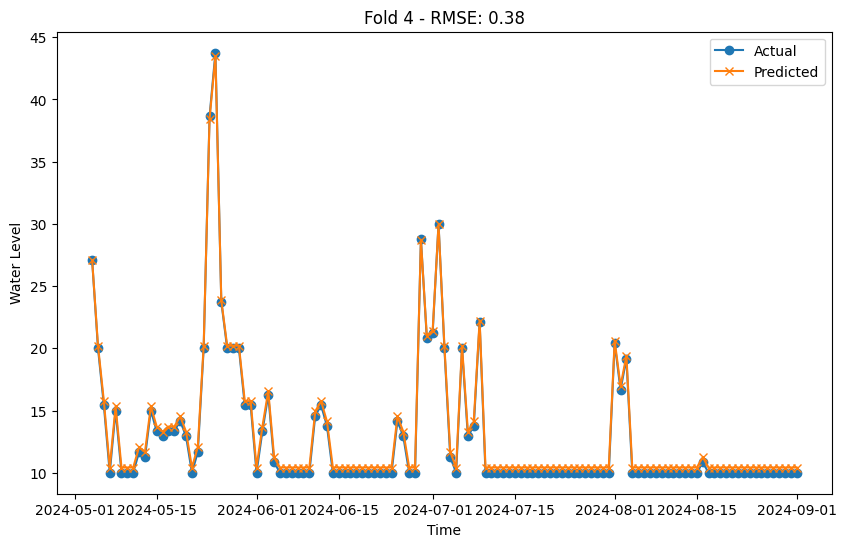

Fold 4 - RMSE: 0.38


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


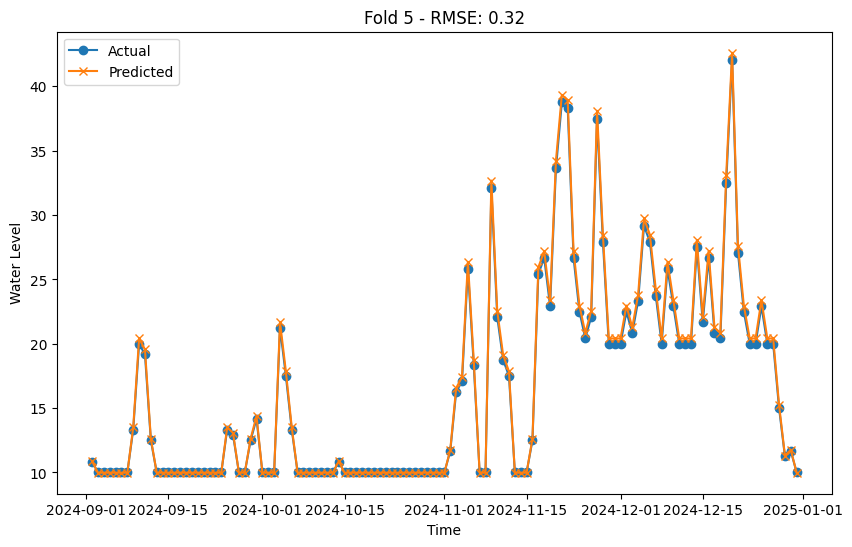

Fold 5 - RMSE: 0.32


In [11]:
#LEARNING RATE: 0,05 dan BATCH SIZE: 16

from sklearn.metrics import mean_squared_error

# Define hyperparameters
learning_rate = 0.05
batch_size = 16
epochs = 100
neurons = 40
time_step = 30

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Initialize list to store RMSE values for each fold
rmse_values = []

# Iterate over each fold
for i, (train_index, test_index) in enumerate(tscv.split(data['TMA_normalized'])):
    train_data, test_data = data.iloc[train_index], data.iloc[test_index]

    # Create and train LSTM model
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(time_step, 1)))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)  # Inisialisasi optimizer dengan learning rate
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    model.fit(train_data['TMA_normalized'].values.reshape(-1, 1),
              train_data['TMA_normalized'].values.reshape(-1, 1),
              epochs=epochs, batch_size=batch_size, verbose=0)

    # Make predictions
    predictions = model.predict(test_data['TMA_normalized'].values.reshape(-1, 1))
    denormalized_predictions = scaler.inverse_transform(predictions)

    # Calculate RMSE
    actual_values = test_data['TMA_Daily'].values
    rmse = np.sqrt(mean_squared_error(actual_values, denormalized_predictions))
    rmse_values.append(rmse)

    # Plot predictions
    plt.figure(figsize=(10, 6))
    plt.plot(test_data['Daily_Period'], actual_values, label='Actual', marker='o')
    plt.plot(test_data['Daily_Period'], denormalized_predictions, label='Predicted', marker='x')
    plt.title(f"Fold {i+1} - RMSE: {rmse:.2f}")
    plt.xlabel('Time')
    plt.ylabel('Water Level')
    plt.legend()
    plt.show()

    print(f"Fold {i+1} - RMSE: {rmse:.2f}")

## Skenario 7

### Learning Rate (0,01) dan Batch Size (32)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


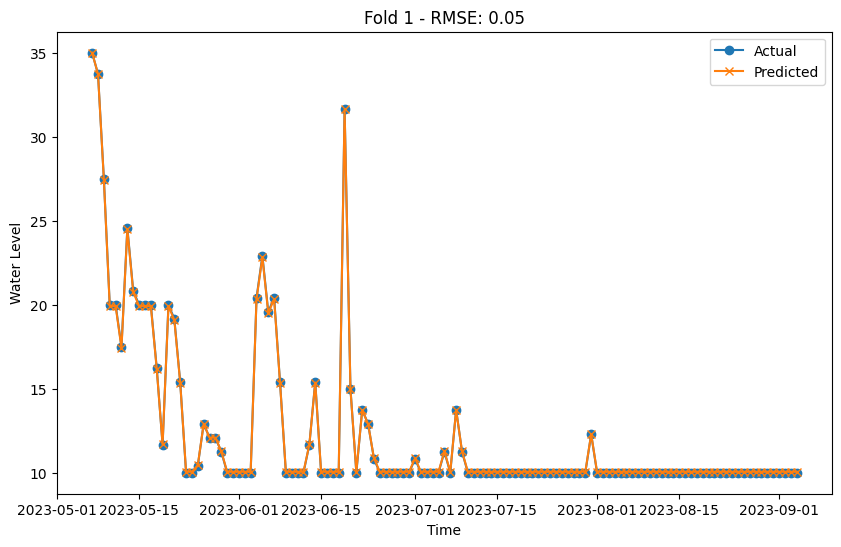

Fold 1 - RMSE: 0.05


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


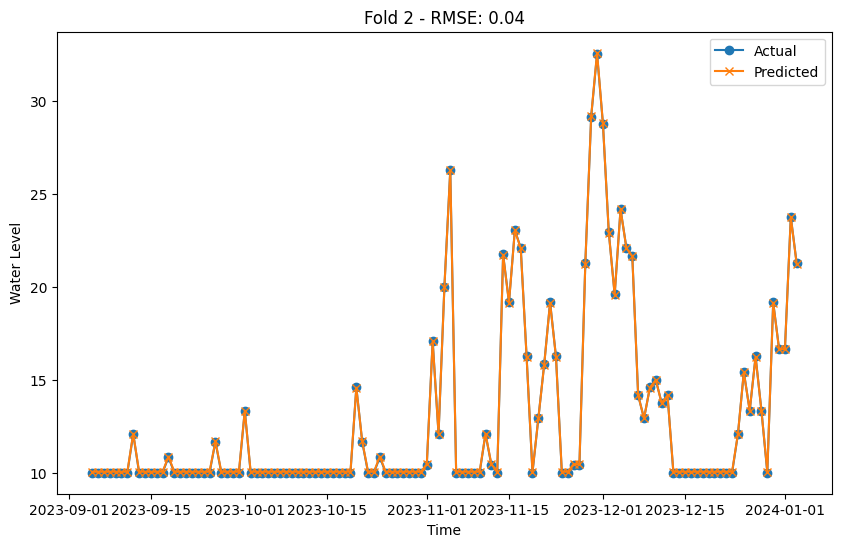

Fold 2 - RMSE: 0.04


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


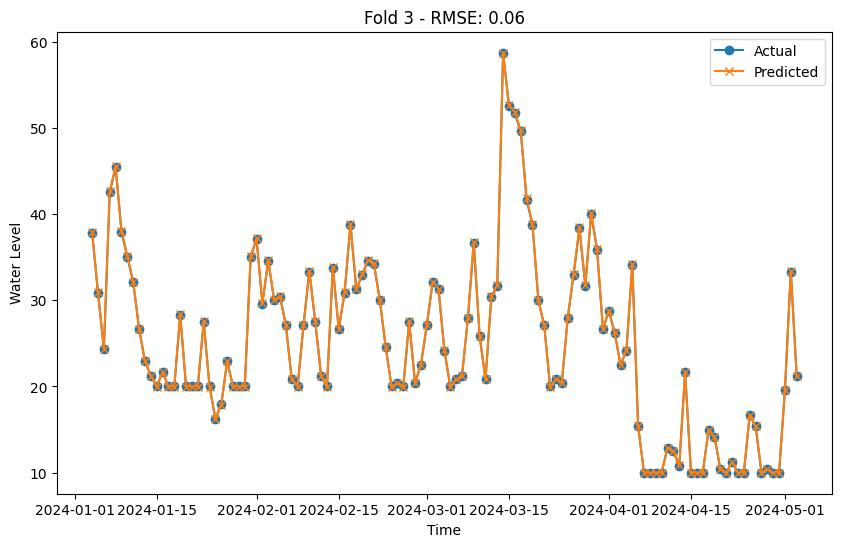

Fold 3 - RMSE: 0.06


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


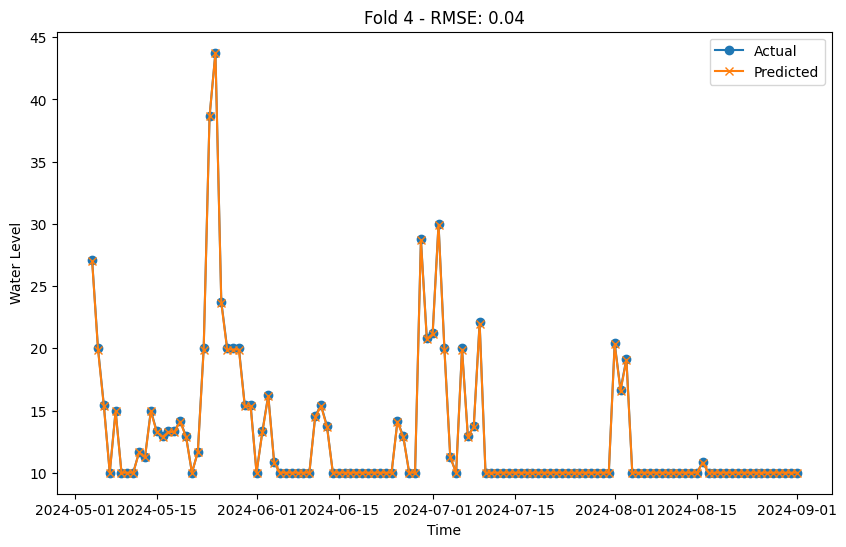

Fold 4 - RMSE: 0.04


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


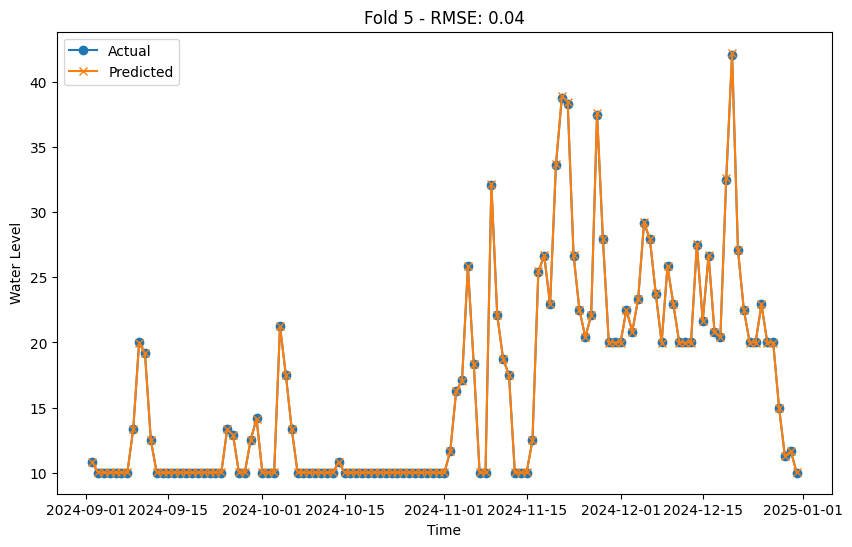

Fold 5 - RMSE: 0.04


In [12]:
#LEARNING RATE: 0,01 dan BATCH SIZE: 32

from sklearn.metrics import mean_squared_error

# Define hyperparameters
learning_rate = 0.01
batch_size = 32
epochs = 100
neurons = 40
time_step = 30

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Initialize list to store RMSE values for each fold
rmse_values = []

# Iterate over each fold
for i, (train_index, test_index) in enumerate(tscv.split(data['TMA_normalized'])):
    train_data, test_data = data.iloc[train_index], data.iloc[test_index]

    # Create and train LSTM model
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(time_step, 1)))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)  # Inisialisasi optimizer dengan learning rate
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    model.fit(train_data['TMA_normalized'].values.reshape(-1, 1),
              train_data['TMA_normalized'].values.reshape(-1, 1),
              epochs=epochs, batch_size=batch_size, verbose=0)

    # Make predictions
    predictions = model.predict(test_data['TMA_normalized'].values.reshape(-1, 1))
    denormalized_predictions = scaler.inverse_transform(predictions)

    # Calculate RMSE
    actual_values = test_data['TMA_Daily'].values
    rmse = np.sqrt(mean_squared_error(actual_values, denormalized_predictions))
    rmse_values.append(rmse)

    # Plot predictions
    plt.figure(figsize=(10, 6))
    plt.plot(test_data['Daily_Period'], actual_values, label='Actual', marker='o')
    plt.plot(test_data['Daily_Period'], denormalized_predictions, label='Predicted', marker='x')
    plt.title(f"Fold {i+1} - RMSE: {rmse:.2f}")
    plt.xlabel('Time')
    plt.ylabel('Water Level')
    plt.legend()
    plt.show()

    print(f"Fold {i+1} - RMSE: {rmse:.2f}")

## Skenario 8

### Learning Rate (0,05) dan Batch Size (32)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


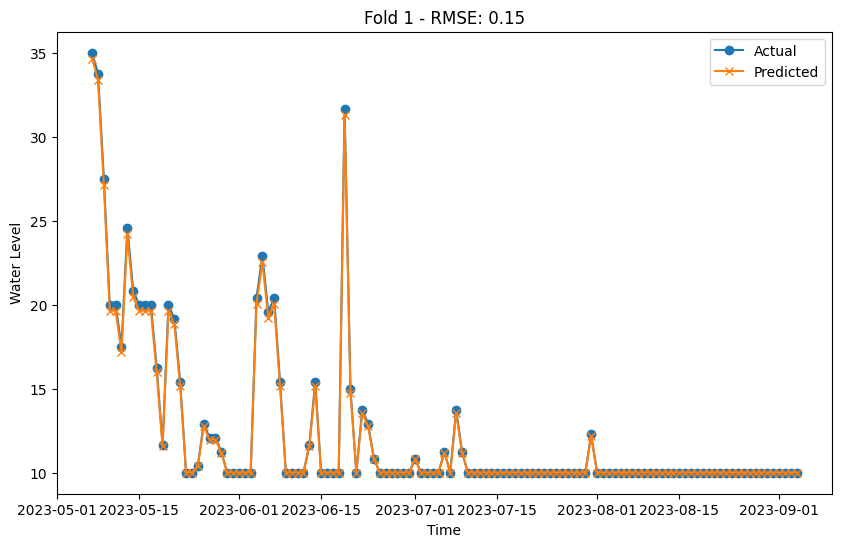

Fold 1 - RMSE: 0.15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


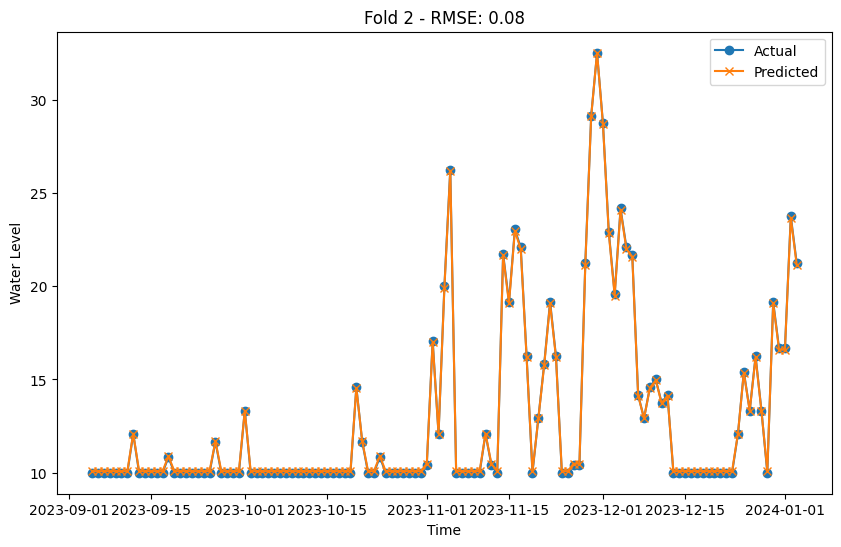

Fold 2 - RMSE: 0.08


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


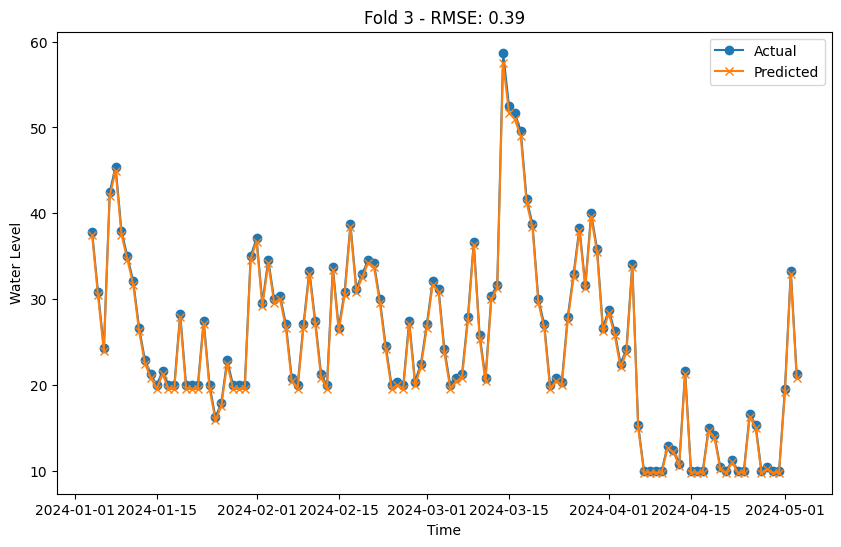

Fold 3 - RMSE: 0.39


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


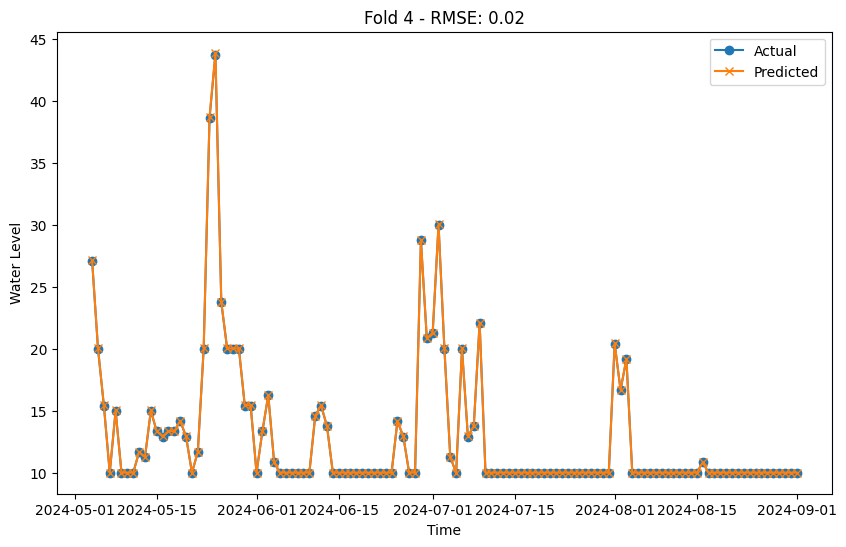

Fold 4 - RMSE: 0.02


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


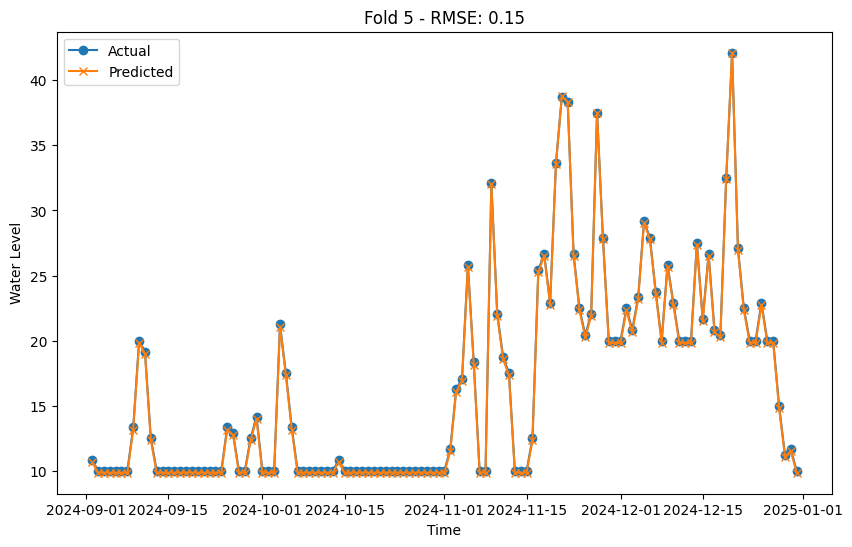

Fold 5 - RMSE: 0.15


In [13]:
#LEARNING RATE: 0,05 dan BATCH SIZE: 32

from sklearn.metrics import mean_squared_error

# Define hyperparameters
learning_rate = 0.05
batch_size = 32
epochs = 100
neurons = 40
time_step = 30

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Initialize list to store RMSE values for each fold
rmse_values = []

# Iterate over each fold
for i, (train_index, test_index) in enumerate(tscv.split(data['TMA_normalized'])):
    train_data, test_data = data.iloc[train_index], data.iloc[test_index]

    # Create and train LSTM model
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(time_step, 1)))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)  # Inisialisasi optimizer dengan learning rate
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    model.fit(train_data['TMA_normalized'].values.reshape(-1, 1),
              train_data['TMA_normalized'].values.reshape(-1, 1),
              epochs=epochs, batch_size=batch_size, verbose=0)

    # Make predictions
    predictions = model.predict(test_data['TMA_normalized'].values.reshape(-1, 1))
    denormalized_predictions = scaler.inverse_transform(predictions)

    # Calculate RMSE
    actual_values = test_data['TMA_Daily'].values
    rmse = np.sqrt(mean_squared_error(actual_values, denormalized_predictions))
    rmse_values.append(rmse)

    # Plot predictions
    plt.figure(figsize=(10, 6))
    plt.plot(test_data['Daily_Period'], actual_values, label='Actual', marker='o')
    plt.plot(test_data['Daily_Period'], denormalized_predictions, label='Predicted', marker='x')
    plt.title(f"Fold {i+1} - RMSE: {rmse:.2f}")
    plt.xlabel('Time')
    plt.ylabel('Water Level')
    plt.legend()
    plt.show()

    print(f"Fold {i+1} - RMSE: {rmse:.2f}")

# Prediksi (Model 2: Skenario Hyperparameter Terbaik)

Skenario Model 2 menghasilkan nilai rata-rata RMSE terkecil dibandingkan skenario model lainnya, dan variasi antar fold nya paling kecil dan lebih stabil.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


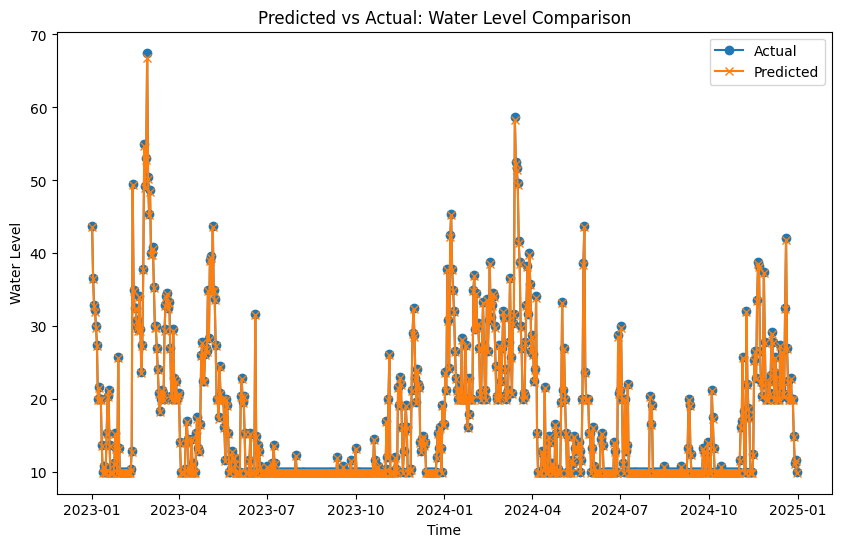

In [17]:
# Prediksi seluruh data

# Import optimizer
from tensorflow.keras.optimizers import Adam

# Define hyperparameters (Rata-rata nilai RMSE terkecil = 0.04)
learning_rate = 0.005
batch_size = 16
epochs = 100
neurons = 40
time_step = 30

# Initialize and compile LSTM model with specified hyperparameters and learning rate
optimizer = Adam(learning_rate=learning_rate)
model = Sequential()
model.add(LSTM(neurons, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=optimizer)

# Train LSTM model
model.fit(data['TMA_normalized'].values.reshape(-1, 1),
          data['TMA_normalized'].values.reshape(-1, 1),
          epochs=epochs, batch_size=batch_size, verbose=0)

# Make predictions for the entire dataset
predictions = model.predict(data['TMA_normalized'].values.reshape(-1, 1))

# Denormalize predictions
denormalized_predictions = scaler.inverse_transform(predictions)

# Plot original data and predicted data
plt.figure(figsize=(10, 6))
plt.plot(data['Daily_Period'], data['TMA_Daily'], label='Actual', marker='o')
plt.plot(data['Daily_Period'], denormalized_predictions, label='Predicted', marker='x')
plt.title("Predicted vs Actual: Water Level Comparison")
plt.xlabel('Time')
plt.ylabel('Water Level')
plt.legend()
plt.show()

In [20]:
denormalized_predictions = pd.DataFrame(denormalized_predictions, columns=['Predictions'])
denormalized_predictions

,Predictions
0,43.551601
1,36.496002
2,32.750607
3,32.008339
4,29.835487
...,...
726,19.850344
727,14.878038
728,11.164585
729,11.576391


In [16]:
denormalized_predictions.to_excel("Predicted_LSTM_Tuning.xlsx", index=False)